Image shape: (512, 768, 3) dtype: float32
Decoded identical to original: True
Compression ratio: 2.105


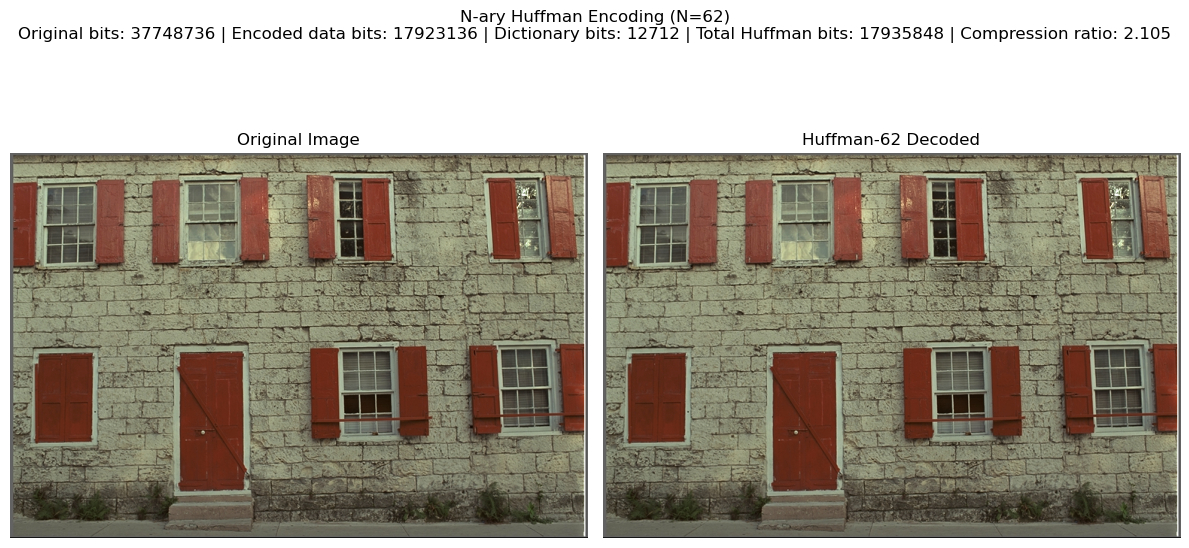

In [1]:
import numpy as np
from collections import Counter
import string
import matplotlib.pyplot as plt

# ---------------- Allowed symbols for N-ary Huffman ---------------- #
# Digits + uppercase + lowercase => 10 + 26 + 26 = 62 symbols
SYMBOLS = string.digits + string.ascii_uppercase + string.ascii_lowercase

# ---------------- Huffman Utilities ---------------- #
def build_nary_huffman(freqs, base):
    heap = [[f, [[sym, ""]]] for sym, f in freqs.items()]
    while len(heap) > 1:
        heap.sort(key=lambda x: x[0])
        children = heap[:base]
        rest = heap[base:]
        total_freq = sum(ch[0] for ch in children)

        newlist = []
        for i, child in enumerate(children):
            for sym, code in child[1]:
                newlist.append([sym, SYMBOLS[i] + code])

        heap = rest + [[total_freq, newlist]]
    return sorted(heap[0][1], key=lambda p: (len(p[-1]), p))

def get_huffman_codebook(freqs, base):
    huff_list = build_nary_huffman(freqs, base)
    return {sym: code for sym, code in huff_list}

# ---------------- Huffman Encode/Decode ---------------- #
def huffman_encode(img, base=2):
    flat = img.flatten()
    freqs = Counter(flat)
    codebook = get_huffman_codebook(freqs, base)

    encoded = [codebook[val] for val in flat]
    return encoded, codebook

def huffman_decode(encoded, codebook, shape, dtype):
    inv_codebook = {v: k for k, v in codebook.items()}
    decoded_vals = []
    buffer = ''
    for sym in encoded:
        buffer += sym
        if buffer in inv_codebook:
            decoded_vals.append(inv_codebook[buffer])
            buffer = ''
    return np.array(decoded_vals, dtype=dtype).reshape(shape)

# ---------------- Compression Ratio ---------------- #
def calculate_huffman_compression_ratio(img, base=2):
    flat = img.flatten()
    orig_bits = img.nbytes * 8  # Total bits in original image

    encoded, codebook = huffman_encode(img, base)

    encoded_bits = sum(len(sym) for sym in encoded) * 8  # SINCE N_MAX = 62, we can assume that each symbol is 1 byte, since that can support upto 256 unique symbols
    dict_bits = 0
    for k, v in codebook.items():
        key_bits = 32  # float or int
        value_bits = len(v) * 8  # 1 byte per symbol
        dict_bits += key_bits + value_bits

    total_bits = encoded_bits + dict_bits
    compression_ratio = orig_bits / total_bits

    return compression_ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded

# ---------------- Visualization ---------------- #
def display_side_by_side(original, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.clip(original, 0, 1) if np.issubdtype(original.dtype, np.floating) else original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(np.clip(decoded, 0, 1) if np.issubdtype(decoded.dtype, np.floating) else decoded)
    axes[1].set_title(f"Huffman-{base} Decoded")
    axes[1].axis("off")

    plt.suptitle(
        f"N-ary Huffman Encoding (N={base})\n"
        f"Original bits: {orig_bits} | "
        f"Encoded data bits: {encoded_bits} | "
        f"Dictionary bits: {dict_bits} | "
        f"Total Huffman bits: {total_bits} | "
        f"Compression ratio: {ratio:.3f}",
        fontsize=12
    )
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

# ---------------- Example Usage ---------------- #
if __name__ == "__main__":
    import matplotlib.image as mpimg

    img = mpimg.imread("/mnt/769EC2439EC1FB9D/vsc_projs/DIP/kodim01.png")       # REPLACE WITH IMAGE PATH....
    if img.dtype in [np.float32, np.float64]:
        img = np.round(img, 4)

    print("Image shape:", img.shape, "dtype:", img.dtype)

    base = 62  # Now maximum supported N
    ratio, orig_bits, encoded_bits, dict_bits, total_bits, codebook, encoded = calculate_huffman_compression_ratio(img, base)
    decoded = huffman_decode(encoded, codebook, img.shape, img.dtype)

    print(f"Decoded identical to original: {np.allclose(img, decoded)}")
    print(f"Compression ratio: {ratio:.3f}")

    display_side_by_side(img, decoded, base, ratio, orig_bits, encoded_bits, dict_bits, total_bits)


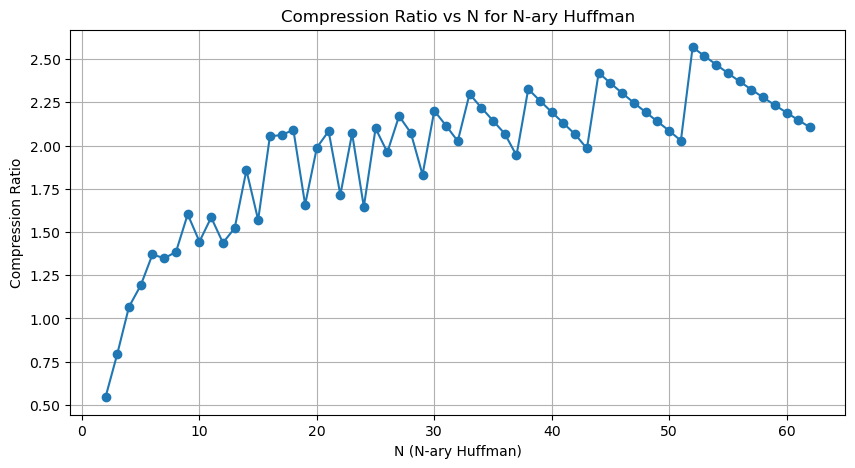

In [2]:
def plot_compression_vs_N(img, max_base=62):
    """
    Computes and plots Huffman compression ratio for N-ary Huffman
    with N from 2 up to max_base.
    
    Parameters:
        img : np.ndarray
            Input image array (int or float).
        max_base : int
            Maximum N value to test (≤ length of SYMBOLS).
    """
    ratios = []
    bases = list(range(2, max_base + 1))
    
    flat = img.flatten()
    orig_bits = img.nbytes * 8
    
    for base in bases:
        freqs = Counter(flat)
        codebook = get_huffman_codebook(freqs, base)
        encoded = [codebook[val] for val in flat]

        # Estimate encoded data size
        encoded_bits = sum(len(sym) for sym in encoded) * 8

        # Estimate dictionary size
        dict_bits = 0
        for k, v in codebook.items():
            key_bits = 32  # assume float/int 32 bits
            value_bits = len(v) * 8
            dict_bits += key_bits + value_bits

        total_bits = encoded_bits + dict_bits
        compression_ratio = orig_bits / total_bits
        ratios.append(compression_ratio)
    
    plt.figure(figsize=(10, 5))
    plt.plot(bases, ratios, marker='o')
    plt.xlabel("N (N-ary Huffman)")
    plt.ylabel("Compression Ratio")
    plt.title("Compression Ratio vs N for N-ary Huffman")
    plt.grid(True)
    plt.show()

img = mpimg.imread("/mnt/769EC2439EC1FB9D/vsc_projs/DIP/kodim01.png")
plot_compression_vs_N(img)